# PARTE B — LOGISTIC REGRESSION One-vs-All (OvA)

Encabezado e imports

In [1]:
# ==============================================================
# PARTE B — LOGISTIC REGRESSION One-vs-All (OvA)
# Dataset: Wine (sklearn.datasets.load_wine)
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.preprocessing import load_wine_data
from utils.logistic_core import logistic_regression_train, predict, sigmoid
from utils.metrics import evaluate_classification

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from pathlib import Path


Entorno de trabajo correctamente configurado.

Versión de Python: 3.10.0
Numpy: 2.2.6
Pandas: 2.3.3
Scikit-learn: 1.7.2
Matplotlib: 3.10.6
Seaborn: 0.13.2
OpenML: 0.15.1
Joblib: 1.5.2


## B.1. Cargamos y estandarizamos Wine

In [2]:
X_train, X_test, y_train, y_test, feature_names, class_names = load_wine_data()
print("Clases:", class_names)
print("Distribución y_train:", np.bincount(y_train))
print("Distribución y_test :", np.bincount(y_test))


✅ Wine cargado y estandarizado
Train: (124, 13) | Test: (54, 13)
Clases: ['class_0', 'class_1', 'class_2']
Distribución y_train: [41 50 33]
Distribución y_test : [18 21 15]


## B.2. Entrenamiento OvA (3 clasificadores binarios)

Usamos el optimizador binario de la Parte A para cada clase k:

In [24]:
# Entrenar 3 clasificadores: "clase k" vs "resto"
K = len(np.unique(y_train))   # 3
weights = []
biases = []
losses_all = []

for k in range(K):
    yk_train = (y_train == k).astype(int)  # binario
    w_k, b_k, L_k = logistic_regression_train(
        X_train, yk_train, lr=0.05, n_iter=2000
    )
    weights.append(w_k)
    biases.append(b_k)
    losses_all.append(L_k)
    print(f"Clase {k} entrenada. Última pérdida: {L_k[-1]:.4f}")


Iteración    0 | Pérdida: 0.6931
Iteración  100 | Pérdida: 0.1552
Iteración  200 | Pérdida: 0.1004
Iteración  300 | Pérdida: 0.0767
Iteración  400 | Pérdida: 0.0631
Iteración  500 | Pérdida: 0.0540
Iteración  600 | Pérdida: 0.0475
Iteración  700 | Pérdida: 0.0426
Iteración  800 | Pérdida: 0.0387
Iteración  900 | Pérdida: 0.0355
Iteración 1000 | Pérdida: 0.0328
Iteración 1100 | Pérdida: 0.0306
Iteración 1200 | Pérdida: 0.0286
Iteración 1300 | Pérdida: 0.0269
Iteración 1400 | Pérdida: 0.0255
Iteración 1500 | Pérdida: 0.0241
Iteración 1600 | Pérdida: 0.0230
Iteración 1700 | Pérdida: 0.0219
Iteración 1800 | Pérdida: 0.0209
Iteración 1900 | Pérdida: 0.0201
Clase 0 entrenada. Última pérdida: 0.0193
Iteración    0 | Pérdida: 0.6931
Iteración  100 | Pérdida: 0.1817
Iteración  200 | Pérdida: 0.1208
Iteración  300 | Pérdida: 0.0949
Iteración  400 | Pérdida: 0.0800
Iteración  500 | Pérdida: 0.0700
Iteración  600 | Pérdida: 0.0628
Iteración  700 | Pérdida: 0.0572
Iteración  800 | Pérdida: 0.0528
I

## B.3. Predicción por probabilidad y argmax

Calculamos probabilidades P(y=k|x) de cada clasificador binario y predecimos la clase con máxima probabilidad:

In [25]:
# Probabilidades por clase (OvA)
probs_test = np.column_stack([
    sigmoid(X_test @ weights[k] + biases[k]) for k in range(K)
])  # shape: (n_samples_test, 3)

y_pred_ova = probs_test.argmax(axis=1)

acc_ova = accuracy_score(y_test, y_pred_ova)
print(f"Accuracy OvA (nuestro): {acc_ova:.5f}")


Accuracy OvA (nuestro): 0.98148


In [26]:
# ==============================================================
# REPORTE DE CLASIFICACIÓN EN TABLA
# ==============================================================

report_dict = classification_report(y_test, y_pred_ova, target_names=class_names, output_dict=True)
df_report_ova = pd.DataFrame(report_dict).transpose().round(5)

print("\n=== Reporte de Clasificación (OvA - Nuestro Modelo) ===")
display(df_report_ova)



=== Reporte de Clasificación (OvA - Nuestro Modelo) ===


,precision,recall,f1-score,support
class_0,0.94737,1.00000,0.97297,18.00000
class_1,1.00000,0.95238,0.97561,21.00000
class_2,1.00000,1.00000,1.00000,15.00000
accuracy,0.98148,0.98148,0.98148,0.98148
macro avg,0.98246,0.98413,0.98286,54.00000
weighted avg,0.98246,0.98148,0.98151,54.00000


In [27]:
# ==============================================================
# RESUMEN GLOBAL (macro y weighted average)
# ==============================================================

summary_ova = df_report_ova.loc[['accuracy', 'macro avg', 'weighted avg']].rename_axis("Resumen")
display(summary_ova)

,precision,recall,f1-score,support
Resumen,,,,
accuracy,0.98148,0.98148,0.98148,0.98148
macro avg,0.98246,0.98413,0.98286,54.00000
weighted avg,0.98246,0.98148,0.98151,54.00000


B.4. Matriz de confusión (guardar figura)

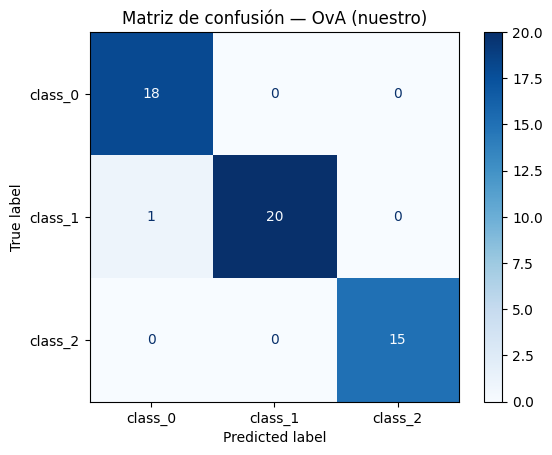

In [28]:
cm = confusion_matrix(y_test, y_pred_ova)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión — OvA (nuestro)")
Path("../report/figuras").mkdir(parents=True, exist_ok=True)
plt.savefig("../report/figuras/matriz_confusion_ova.png", dpi=300)
plt.show()


## B.5. Comparación con sklearn (OvR)

In [29]:

# ==============================================================
# ENTRENAMIENTO CON SKLEARN (OvR)
# ==============================================================

clf_ovr = LogisticRegression(multi_class="ovr", max_iter=5000)
clf_ovr.fit(X_train, y_train)
y_pred_sk = clf_ovr.predict(X_test)

# Accuracy global
acc_sk = accuracy_score(y_test, y_pred_sk)
print(f"Accuracy OvR (sklearn): {acc_sk:.5f}")



Accuracy OvR (sklearn): 0.98148


c:\Users\pc\Desktop\PEU DATA SCIENCE INEI\PEU INEI\ALEXANDER ML\PRACTICAS\TAREA 2\ENEI-2025-ML1-Tarea2\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [30]:
# ==============================================================
# REPORTE DE CLASIFICACIÓN EN TABLA
# ==============================================================

# Crear DataFrame con las métricas
report_dict = classification_report(y_test, y_pred_sk, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Redondear valores
df_report = df_report.round(5)

# Mostrar tabla limpia
print("\n=== Reporte de Clasificación (sklearn OvR) ===")
display(df_report)



=== Reporte de Clasificación (sklearn OvR) ===


,precision,recall,f1-score,support
class_0,0.94737,1.00000,0.97297,18.00000
class_1,1.00000,0.95238,0.97561,21.00000
class_2,1.00000,1.00000,1.00000,15.00000
accuracy,0.98148,0.98148,0.98148,0.98148
macro avg,0.98246,0.98413,0.98286,54.00000
weighted avg,0.98246,0.98148,0.98151,54.00000


In [19]:

# ==============================================================
#  Mostrar tabla resumen de métricas promedio
# ==============================================================

summary = df_report.loc[['accuracy', 'macro avg', 'weighted avg']].rename_axis("Resumen")
display(summary)


,precision,recall,f1-score,support
Resumen,,,,
accuracy,0.98148,0.98148,0.98148,0.98148
macro avg,0.98246,0.98413,0.98286,54.00000
weighted avg,0.98246,0.98148,0.98151,54.00000


## B.6. Comparación de coeficientes (heatmap y archivo)

Preparamos dos matrices de coeficientes: nuestros y sklearn, y graficamos la diferencia (nuestro-sklearn).

=== Diferencia de coeficientes (nuestro − sklearn) ===


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
cls_0,0.3627,0.1334,0.2006,-0.4352,0.0098,0.1136,0.2765,0.0865,-0.1866,0.0837,0.0369,0.1766,0.4649
cls_1,-0.4774,-0.1841,-0.3184,0.2133,-0.1639,-0.0380,-0.0275,0.0424,0.2201,-0.3332,0.2993,0.0864,-0.4771
cls_2,0.0773,0.0701,0.0728,-0.1133,-0.0849,0.0966,-0.1407,-0.2357,0.2207,0.5716,-0.0753,-0.0330,-0.0832


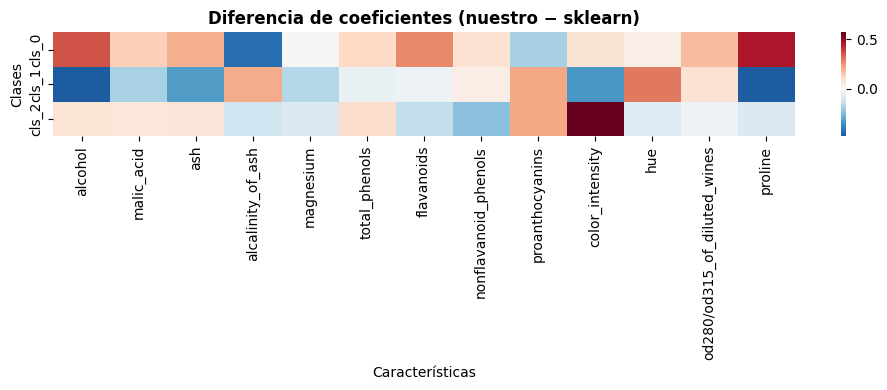

In [12]:

# ==============================================================
# COMPARACIÓN DE COEFICIENTES ENTRE NUESTRO MODELO Y SKLEARN
# ==============================================================

our_coef = np.vstack(weights)              # (K, n_features)
sk_coef  = clf_ovr.coef_                   # (K, n_features)

df_diff = pd.DataFrame(
    our_coef - sk_coef,
    index=[f"cls_{k}" for k in range(K)],
    columns=feature_names
)

# Mostrar tabla con valores redondeados
print("=== Diferencia de coeficientes (nuestro − sklearn) ===")
display(df_diff.round(4))

# Visualizar diferencias
plt.figure(figsize=(10, 4))
sns.heatmap(df_diff, cmap="RdBu_r", center=0, annot=False)
plt.title("Diferencia de coeficientes (nuestro − sklearn)", fontsize=12, weight='bold')
plt.xlabel("Características")
plt.ylabel("Clases")
plt.tight_layout()
plt.savefig("../report/figuras/comparacion_coeficientes.png", dpi=300)
plt.show()



In [13]:
# ==============================================================
# TOP 5 CARACTERÍSTICAS MÁS IMPORTANTES POR CLASE
# ==============================================================
df_top = pd.DataFrame()

for k in range(K):
    top = (pd.Series(our_coef[k], index=feature_names)
           .abs().sort_values(ascending=False)
           .head(5))
    df_top[f"Clase {k} ({class_names[k]})"] = top.index

print("\n=== Top-5 características más influyentes por clase ===")
display(df_top)



=== Top-5 características más influyentes por clase ===


,Clase 0 (class_0),Clase 1 (class_1),Clase 2 (class_2)
0,proline,proline,color_intensity
1,alcalinity_of_ash,alcohol,flavanoids
2,alcohol,color_intensity,hue
3,flavanoids,ash,od280/od315_of_diluted_wines
4,ash,hue,ash
